# Dropout
저번시간에 짰던 코드에 Dropout을 추가함

# module import

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets

# device 설정

In [32]:
#@title 기본 제목 텍스트
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('Using PyTorch version :', torch.__version__, ' Device :', DEVICE)

Using PyTorch version : 1.7.0+cu101  Device : cuda


# Hyper parameter 설정

In [33]:
class Config(dict): 
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)


config = Config({
    'batch_size' : 32,
    'epochs': 30,
    'learning_rate': 0.01
})

# MNIST 데이터 다운로드
Train set과 Test set 분리하기

In [34]:
# MNIST 데이터 다운로드
train_dataset = datasets.MNIST(root="../data/MNIST",
                               train=True,
                               download=True,
                               transform=transforms.ToTensor())

test_dataset = datasets.MNIST(root="../data/MNIST",
                              train=False,
                              transform=transforms.ToTensor())


# 다운로드한 데이터를 Mini_Batch 단위로 분리해 저장
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=config.batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=config.batch_size,
                                          shuffle=False)

# 데이터 확인

In [35]:
for X_train, Y_train in train_loader:
    print('X_train :', X_train.size(), 'type :', X_train.type())
    print('Y_train :', Y_train.size(), 'type :', Y_train.type())
    break

X_train : torch.Size([32, 1, 28, 28]) type : torch.FloatTensor
Y_train : torch.Size([32]) type : torch.LongTensor


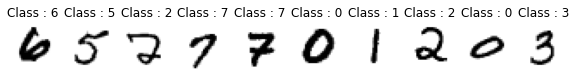

In [36]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap="gray_r")
    plt.title('Class : '+str(Y_train[i].item()))

# Model 설계하기

In [37]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        # 50%의 노드는 가중값을 계산하지 않음.
        self.dropout_prob = 0.5

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = nn.functional.sigmoid(x)

        # Dropout을 적용하는 부분이다.
        # trainig은 학습 상태일 때는 dropout을 적용, 아닐 때는
        # 적용하지 않기 위함.
        # p부분은 dropout을 계산하지 않을 확률
        x = nn.functional.dropout(x, training=self.training, p=self.dropout_prob)

        x = self.fc2(x)
        x = nn.functional.sigmoid(x)
        # 마찬가지
        x = nn.functional.dropout(x, training=self.training, p=self.dropout_prob)
        x = self.fc3(x)
        x = nn.functional.log_softmax(x, dim=1)
        return x

# loss function, optimizer 설정하기

In [38]:
model = Net().to(DEVICE)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=config.learning_rate,
                      momentum=0.5)

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


# MLP 모델 학습하는 함수 정의

In [39]:
def train(model, train_loader, optimizer, log_interval):
    model.train()

    for batch_idx, (image, lable) in enumerate(train_loader):
        image = image.to(DEVICE)
        lable = lable.to(DEVICE)
        optimizer.zero_grad()
        out = model(image)
        loss = loss_function(out, lable)
        loss.backward()
        optimizer.step()

        # if batch_idx % log_interval == 0:
        #     print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(
        #         Epoch, batch_idx*len(image),
        #         len(train_loader.dataset), 100.*batch_idx / len(train_loader),
        #         loss.item()
        #     ))

# 학습하는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의

In [40]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    # 검증 과정 중에는 파라메터 값이 업데이트 되면 안되므로,
    # no_grad()를 이용하여, gradient의 흐름을 억제
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            out = model(image)
            test_loss += loss_function(out, label).item()
            prediction = out.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100.*correct/len(test_loader.dataset)
    return test_loss, test_accuracy

# 학습 실행

In [41]:
for Epoch in range(1, config.epochs+1):
    train(model, train_loader, optimizer, log_interval=200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print()
    print("[EPOCH: {}], \tTest Loss : {:.4f}, \tTest Accuracy : {:.2f} %\n".
          format(Epoch, test_loss, test_accuracy))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



[EPOCH: 1], 	Test Loss : 0.0714, 	Test Accuracy : 20.25 %


[EPOCH: 2], 	Test Loss : 0.0645, 	Test Accuracy : 43.92 %


[EPOCH: 3], 	Test Loss : 0.0390, 	Test Accuracy : 57.31 %


[EPOCH: 4], 	Test Loss : 0.0278, 	Test Accuracy : 71.68 %


[EPOCH: 5], 	Test Loss : 0.0236, 	Test Accuracy : 76.17 %


[EPOCH: 6], 	Test Loss : 0.0200, 	Test Accuracy : 80.95 %


[EPOCH: 7], 	Test Loss : 0.0176, 	Test Accuracy : 83.40 %


[EPOCH: 8], 	Test Loss : 0.0160, 	Test Accuracy : 84.95 %


[EPOCH: 9], 	Test Loss : 0.0148, 	Test Accuracy : 85.85 %


[EPOCH: 10], 	Test Loss : 0.0139, 	Test Accuracy : 86.80 %


[EPOCH: 11], 	Test Loss : 0.0132, 	Test Accuracy : 87.38 %


[EPOCH: 12], 	Test Loss : 0.0126, 	Test Accuracy : 87.90 %


[EPOCH: 13], 	Test Loss : 0.0122, 	Test Accuracy : 88.32 %


[EPOCH: 14], 	Test Loss : 0.0118, 	Test Accuracy : 88.73 %


[EPOCH: 15], 	Test Loss : 0.0115, 	Test Accuracy : 88.93 %


[EPOCH: 16], 	Test Loss : 0.0111, 	Test Accuracy : 89.33 %


[EPOCH: 17], 	Test Loss : 0.0108